# Big Data Cup 2024 -

#### Zeke Weng, Alexander Khan, Daniel Du, Samarth Sharma

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample
!pip install hockey_rink
from hockey_rink import NHLRink, RinkImage, Rink
from datetime import datetime

from scipy.stats import mannwhitneyu

In [69]:
bdc2024 = pd.read_csv('https://github.com/bigdatacup/Big-Data-Cup-2024/blob/main/BDC_2024_Womens_Data.csv?raw=true')
bdc2021 = pd.read_csv('https://github.com/bigdatacup/Big-Data-Cup-2021/blob/main/pxp_womens_oly_2022_v2.csv?raw=true')
bdc2024_shifts = pd.read_csv('https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2024/fe522b1c4782d3ba13764c53fc604e7ec6856ae7/BDC_2024_Womens_Shifts.csv')

In [70]:
### Functions
goal = (189,42.5) # Middle of Net (X Coordinate: 11 from backwall so 200 - 11, Y Coordinate: center of Y so 85/2)

def calculate_distance(row):
    return np.sqrt((row['X Coordinate'] - goal[0]) ** 2 + (row['Y Coordinate'] - goal[1]) ** 2)

def calculate_angle(row):
    if row['X Coordinate'] >= 189:
        return 0
    c = 6 # length of the goal
    a = np.sqrt((row['X Coordinate'] - goal[0]) ** 2 + (row['Y Coordinate'] - goal[1] - c/2) ** 2)
    b = np.sqrt((row['X Coordinate'] - goal[0]) ** 2 + (row['Y Coordinate'] - goal[1] + c/2) ** 2)
    cos_C = (a**2 + b**2 - c**2) / (2 * a * b)
    angle = np.arccos(cos_C)
    angle = np.degrees(angle)
    return angle

def convert_clock(row, column_name):
    minutes, seconds = map(int, row[column_name].split(':'))
    return minutes * 60 + seconds

def map_to_zone(row):
    if row['Zone_Entry'] == 1:
        if (row['Y Coordinate'] < 7.5) or (row['Y Coordinate'] > 77.5):
            return 1
        elif (row['Y Coordinate'] <= 62.5) and (row['Y Coordinate'] >= 22.5):
            return 3
        else:
            return 2
    return 0

def assign_predicted_xG(row):
    if row['Zone'] == 0:
        return 0
    elif row['Detail 1'] != 'Dumped':
        Zone = row['Zone']
        Type = row['Detail 1']
        return ZonesxTypes_to_xG[f"Zone_{Zone}_{Type}"]
    else:
        return Types_to_xG['Dumped']

def assign_shot_xG(row):
    if row['Event'] == 'Shot':
        return model.predict_proba(row[['Angle', 'Distance']].values.reshape(1, -1))[0,1]
    else:
        return 0

def get_defenders(row, shifts_df):
    filtered_shifts = shifts_df[
        (shifts_df['Game'] == row['Game']) &
        (shifts_df['Period'] == row['Period']) &
        (shifts_df['Team'] != row['Team']) &
        (shifts_df['Start_Clock'] >= row['Clock']) &
        (shifts_df['End_Clock'] < row['Clock'])
    ]
    return filtered_shifts['Player'].unique()

In [71]:
### Renames bdc2021 Columns
bdc2021 = bdc2021.rename(columns={
    'x_coord': 'X Coordinate',
    'y_coord': 'Y Coordinate',
    'event': 'Event',
    'player_name': 'Player',
    'event_type': 'Detail 1',
    'event_detail_1': 'Detail 2',
    'event_detail_2': 'Detail 3',
    'event_detail_3': 'Detail 4',
    'team_name': 'Team',
    'game_date': 'Date',
    'clock_seconds': 'Clock',
    'x_coord_2': 'X Coordinate 2',
    'y_coord_2': 'Y Coordinate 2',
    'player_name_2': 'Player 2',
    'period': 'Period',
    'opp_team_name': 'opponent'
    })

bdc2024_shifts= bdc2024_shifts.rename(columns={
    'team_name': 'Team',
    'player_name': 'Player',
    'period': 'Period',
    'start_clock': 'Start_Clock',
    'end_clock': 'End_Clock'
    })

bdc2021['Team'] = bdc2021['Team'].replace({
    'Olympic (Women) - Canada': 'Women - Canada',
    'Olympic (Women) - United States': 'Women - United States',
    'Olympic (Women) - Finland': 'Women - Finland',
    'Olympic (Women) - Olympic Athletes from Russia': 'Women - Russia',
    'Olympic (Women) - Switzerland': 'Women - Switzerland'
    })

### Updates bdc2024 & bdc2024_shifts Clock
bdc2024['Clock'] = bdc2024.apply(convert_clock, column_name='Clock', axis=1)
bdc2024_shifts['Start_Clock'] = bdc2024_shifts.apply(convert_clock, column_name='Start_Clock', axis=1)
bdc2024_shifts['End_Clock'] = bdc2024_shifts.apply(convert_clock, column_name='End_Clock', axis=1)

### Creates Shot_Result Column (For Goals)
# 2024
bdc2024['Shot_Result'] = 0
bdc2024.loc[bdc2024['Event'] == 'Goal','Shot_Result'] = 1
bdc2024 = bdc2024.replace('Goal','Shot')
# 2021
bdc2021['Shot_Result'] = 0
bdc2021.loc[(bdc2021['event_successful'] == 't') & (bdc2021['Event'] == 'Shot'),'Shot_Result'] = 1

### Step 1: xG Model (Angle and Distance)

A simple xG Model utilizing Logistic Regression with features angles and distance.

In [72]:
# Data Preparation
df = pd.concat([bdc2021[['Clock', 'Team', 'Event', 'X Coordinate', 'Y Coordinate', 'Shot_Result', 'Detail 1']], bdc2024[['Clock', 'Team', 'Event', 'X Coordinate', 'Y Coordinate', 'Shot_Result', 'Detail 1']]],ignore_index=True)
df['Angle'] = df.apply(calculate_angle, axis=1)
df['Distance'] = df.apply(calculate_distance, axis=1)

shots = df[df['Event']=='Shot']

# Logistic Regression Model (xG)
np.random.seed(42)

X, y = shots[['Angle','Distance']], shots['Shot_Result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100000)
m = model.fit(X_train, y_train)

df['xG'] = model.predict_proba(df[['Angle', 'Distance']])[:,1]

In [73]:
# Creating Plotting DataFrame
plotting_df = df.copy()
plotting_df['X Coordinate'] = plotting_df['X Coordinate'] - 100
plotting_df['Y Coordinate'] = plotting_df['Y Coordinate'] - 42.5

<Axes: >

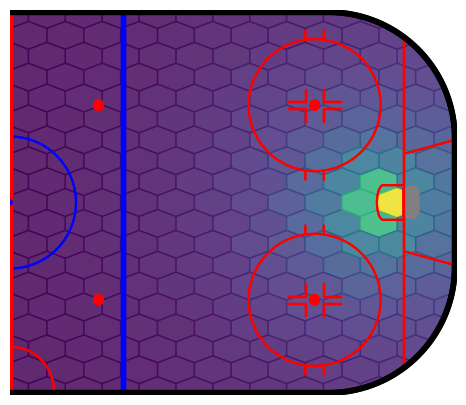

In [74]:
fig, axs = plt.subplots(figsize=(12, 5))
rink = Rink(boards={"length": 200, "width": 85})

rink.hexbin(
    "X Coordinate", "Y Coordinate", "xG", data=plotting_df,
    gridsize=(24, 9), plot_range="offense",
    alpha=0.85, vmax=0.25,
    ax=axs, draw_kw={"display_range": "offense"}
)

rink.draw(display_range="offense", ax=axs)
# rink.hexbin(
#     "x", "y", "is_goal", data=ozone_shots,
#     gridsize=(14, 8), plot_range="ozone", alpha=0.85, vmax=0.25,
#     ax=axs[2], draw_kw={"display_range": "ozone"},
# )

### Step 2: Zone Entry Analysis

Divides Zone Entries into Thirds: \\
Zone 1: Outermost 7.5 Feet \\
Zone 2: Next 15 Feet \\
Zone 3: Remaining 20 Feet \\
42.5 Cuz we view it symmetrically \\

In [75]:
# Creates Possession Change and Possession Columns
df['Possession Change'] = df['Team'].ne(df['Team'].shift()).astype(int)
df.loc[df['Shot_Result'] == 1, 'Possession Change'] = 1
df.loc[df['Clock'] == '20:00', 'Possession Change'] = 1

df['Possession'] = df['Possession Change'].cumsum()

# Creates PreZone_Entry, Zone_Entry, PostZone_Entry Columns
df[['PreZone_Entry', 'Zone_Entry', 'PostZone_Entry']] = 0
df.loc[((df['Event'] == 'Zone Entry') & (df['X Coordinate'] < 130) & (df['X Coordinate'] > 120)), 'Zone_Entry'] = 1
df.loc[(df['X Coordinate'] < 125) & (df['Zone_Entry'] != 1), 'PreZone_Entry'] = 1
df.loc[(df['X Coordinate'] > 125) & (df['Zone_Entry'] != 1), 'PostZone_Entry'] = 1

# Creates Zone Column for Zone Entries
df['Zone'] = df.apply(map_to_zone, axis=1)

### Zones (1,2,3) versus xG



In [76]:
df[df['Zone_Entry']==1].groupby(by='Detail 1').count()

,Clock,Team,Event,X Coordinate,Y Coordinate,Shot_Result,Angle,Distance,xG,Possession Change,Possession,PreZone_Entry,Zone_Entry,PostZone_Entry,Zone
Detail 1,,,,,,,,,,,,,,,
Carried,687,687,687,687,687,687,687,687,687,687,687,687,687,687,687
Dumped,466,466,466,466,466,466,466,466,466,466,466,466,466,466,466
Played,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120


In [77]:
Zone_Names = ['Zone_1', 'Zone_2', 'Zone_3']
p_xG = []
Zone_1 = df[(df['Zone_Entry']==1) & (df['Zone']==1)]['Possession'].to_list()
Zone_2 = df[(df['Zone_Entry']==1) & (df['Zone']==2)]['Possession'].to_list()
Zone_3 = df[(df['Zone_Entry']==1) & (df['Zone']==3)]['Possession'].to_list()
Zones = [Zone_1, Zone_2, Zone_3]

# Iterate through the Zones
for Zone in Zones:
    sum = 0
    # Iterate through the Possessions
    for Possession in Zone:
        # Add Cumulative xG for each shot taken in possession (Could be no shots taken)
        try:
            xG_values = df[(df['Possession']==Possession) & (df['PostZone_Entry']==1) & (df['Event']=='Shot')].xG.values
            for value in xG_values:
                sum += value
        except:
            pass
        # Average xG per Possession for that Zone
    p_xG.append(sum/len(Zone))

Zones_to_xG = dict(zip(Zone_Names, p_xG))
Zones_to_xG

{'Zone_1': 0.016302842142278902,
 'Zone_2': 0.023287883936209078,
 'Zone_3': 0.02478625512218038}

### Zone Entry Types ('Carried', 'Dumped', 'Played') versus xG

In [78]:
df[df['Zone_Entry']==1].groupby(by='Detail 1').count()

,Clock,Team,Event,X Coordinate,Y Coordinate,Shot_Result,Angle,Distance,xG,Possession Change,Possession,PreZone_Entry,Zone_Entry,PostZone_Entry,Zone
Detail 1,,,,,,,,,,,,,,,
Carried,687,687,687,687,687,687,687,687,687,687,687,687,687,687,687
Dumped,466,466,466,466,466,466,466,466,466,466,466,466,466,466,466
Played,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120


In [79]:
Type_Names = ['Carried', 'Dumped', 'Played']
p_xG = []
Carried = df[(df['Zone_Entry']==1) & (df['Detail 1']=='Carried')]['Possession'].to_list()
Dumped = df[(df['Zone_Entry']==1) & (df['Detail 1']=='Dumped')]['Possession'].to_list()
Played = df[(df['Zone_Entry']==1) & (df['Detail 1']=='Played')]['Possession'].to_list()
Types = [Carried, Dumped, Played]

TypeCounts = [687, 466, 120]
xG_all = []

# Iterate through the Types
for Type in Types:
    xG_vals = []
    sum = 0
    # Iterate through the Possessions
    for Possession in Type:
        # Add Cumulative xG for each shot taken in possession (Could be no shots taken)
        try:
            xG_values = df[(df['Possession']==Possession) & (df['PostZone_Entry']==1) & (df['Event']=='Shot')].xG.values
            for value in xG_values:
                sum += value
                xG_vals.append(value)
        except:
            pass
    while len(xG_vals) < TypeCounts[Types.index(Type)]:
      xG_vals.append(0)
    # Average xG per Possession for that Type
    p_xG.append(sum/len(Type))
    # Recording all individual xG values for that Type
    xG_all.append(xG_vals)
Types_to_xG = dict(zip(Type_Names, p_xG))
Types_to_xG

{'Carried': 0.03026641042978742,
 'Dumped': 0.005699255628345039,
 'Played': 0.021016343241199}

### Zones (1,2,3) versus xG [Minus Dumped]

In [80]:
df[(df['Zone_Entry']==1) & (df['Detail 1']!='Dumped')].groupby(by='Zone').count()

,Clock,Team,Event,X Coordinate,Y Coordinate,Shot_Result,Detail 1,Angle,Distance,xG,Possession Change,Possession,PreZone_Entry,Zone_Entry,PostZone_Entry
Zone,,,,,,,,,,,,,,,
1,317,317,317,317,317,317,317,317,317,317,317,317,317,317,317
2,266,266,266,266,266,266,266,266,266,266,266,266,266,266,266
3,224,224,224,224,224,224,224,224,224,224,224,224,224,224,224


In [81]:
Zone_Names = ['Zone_1_MD', 'Zone_2_MD', 'Zone_3_MD']
p_xG = []
Zone_1 = df[(df['Zone_Entry']==1) & (df['Zone']==1) & (df['Detail 1']!='Dumped')]['Possession'].to_list()
Zone_2 = df[(df['Zone_Entry']==1) & (df['Zone']==2) & (df['Detail 1']!='Dumped')]['Possession'].to_list()
Zone_3 = df[(df['Zone_Entry']==1) & (df['Zone']==3) & (df['Detail 1']!='Dumped')]['Possession'].to_list()
Zones = [Zone_1, Zone_2, Zone_3]

# Iterate through the Zones
for Zone in Zones:
    sum = 0
    # Iterate through the Possessions
    for Possession in Zone:
        # Add Cumulative xG for each shot taken in possession (Could be no shots taken)
        try:
            xG_values = df[(df['Possession']==Possession) & (df['PostZone_Entry']==1) & (df['Event']=='Shot')].xG.values
            for value in xG_values:
                sum += value
        except:
            pass
    # Average xG per Possession for that Zone
    p_xG.append(sum/len(Zone))
Zones_to_xG_MD = dict(zip(Zone_Names, p_xG))
Zones_to_xG_MD

{'Zone_1_MD': 0.024959889961873396,
 'Zone_2_MD': 0.029645132401941533,
 'Zone_3_MD': 0.033558459006149594}

### Zones (1,2,3) x (Played, Carried) versus xG

In [82]:
df[(df['Zone_Entry']==1) & (df['Detail 1']!='Dumped')].groupby(by=['Zone','Detail 1']).count()

Clock  Team  Event  X Coordinate  Y Coordinate  Shot_Result  \
Zone Detail 1                                                                
1    Carried     278   278    278           278           278          278   
     Played       39    39     39            39            39           39   
2    Carried     222   222    222           222           222          222   
     Played       44    44     44            44            44           44   
3    Carried     187   187    187           187           187          187   
     Played       37    37     37            37            37           37   

               Angle  Distance   xG  Possession Change  Possession  \
Zone Detail 1                                                        
1    Carried     278       278  278                278         278   
     Played       39        39   39                 39          39   
2    Carried     222       222  222                222         222   
     Played       44        44   44                 44          44   
3    Carried     187       187  187                187         187   
     Played       37        37   37                 37          37   

               PreZone_Entry  Zone_Entry  PostZone_Entry  
Zone Detail 1                                             
1    Carried             278         278             278  
     Played               39          39              39  
2    Carried             222         222             222  
     Played               44          44              44  
3    Carried             187         187             187  
     Played               37          37              37

In [83]:
Names = ['Zone_1_Carried', 'Zone_2_Carried', 'Zone_3_Carried', 'Zone_1_Played', 'Zone_2_Played', 'Zone_3_Played']
p_xG = []
Zone_1_Carried = df[(df['Zone_Entry']==1) & (df['Zone']==1) & (df['Detail 1']=='Carried')]['Possession'].to_list()
Zone_2_Carried = df[(df['Zone_Entry']==1) & (df['Zone']==2) & (df['Detail 1']=='Carried')]['Possession'].to_list()
Zone_3_Carried = df[(df['Zone_Entry']==1) & (df['Zone']==3) & (df['Detail 1']=='Carried')]['Possession'].to_list()
Zone_1_Played = df[(df['Zone_Entry']==1) & (df['Zone']==1) & (df['Detail 1']=='Played')]['Possession'].to_list()
Zone_2_Played = df[(df['Zone_Entry']==1) & (df['Zone']==2) & (df['Detail 1']=='Played')]['Possession'].to_list()
Zone_3_Played = df[(df['Zone_Entry']==1) & (df['Zone']==3) & (df['Detail 1']=='Played')]['Possession'].to_list()
ZonesxTypes = [Zone_1_Carried, Zone_2_Carried, Zone_3_Carried, Zone_1_Played, Zone_2_Played, Zone_3_Played]

# Iterate through the ZonesxTypes
for ZT in ZonesxTypes:
    sum = 0
    # Iterate through the Possessions
    for Possession in ZT:
    # Add Cumulative xG for each shot taken in possession (Could be no shots taken)
        try:
            xG_values = df[(df['Possession']==Possession) & (df['PostZone_Entry']==1) & (df['Event']=='Shot')].xG.values
            for value in xG_values:
                sum += value
        except:
            pass
    # Average xG per Possession for that ZonexType
    p_xG.append(sum/len(ZT))
ZonesxTypes_to_xG = dict(zip(Names, p_xG))
ZonesxTypes_to_xG

# Check direction of the pass for Played -- If pass goes to the outer zone ##

{'Zone_1_Carried': 0.025821939199700043,
 'Zone_2_Carried': 0.030083155710256708,
 'Zone_3_Carried': 0.03709125294155261,
 'Zone_1_Played': 0.018815026164032123,
 'Zone_2_Played': 0.027435105709987685,
 'Zone_3_Played': 0.015703527494788354}

In [84]:
# fig, ax = plt.subplots(figsize=(25, 6))

# analysis_dict = {**Zones_to_xG, **Zones_to_xG_MD, **Types_to_xG, **ZonesxTypes_to_xG}
# analysis_df = pd.DataFrame.from_dict(analysis_dict, orient='index', columns=['xG'])

# analysis_df
# plt.bar(analysis_df.index, analysis_df['xG'])

In [85]:
# Creates PreZone_Entry, Zone_Entry, PostZone_Entry Columns
bdc2024[['PreZone_Entry', 'Zone_Entry', 'PostZone_Entry']] = 0
bdc2024.loc[((bdc2024['Event'] == 'Zone Entry') & (bdc2024['X Coordinate'] < 130) & (bdc2024['X Coordinate'] > 120)), 'Zone_Entry'] = 1
bdc2024.loc[(bdc2024['X Coordinate'] < 125) & (bdc2024['Zone_Entry'] != 1), 'PreZone_Entry'] = 1
bdc2024.loc[(bdc2024['X Coordinate'] > 125) & (bdc2024['Zone_Entry'] != 1), 'PostZone_Entry'] = 1

# Creates Angle, Distance, Zone, xG Columns
bdc2024['Angle'] = bdc2024.apply(calculate_angle, axis=1)
bdc2024['Distance'] = bdc2024.apply(calculate_distance, axis=1)
bdc2024['Zone'] = bdc2024.apply(map_to_zone, axis=1)
bdc2024['predicted_xG'] = bdc2024.apply(assign_predicted_xG, axis=1)

# Creates Game Column
bdc2024['Game'] = 0
bdc2024_shifts['Game'] = 0
for date, index in zip(bdc2024.Date.unique(), range(1,5)):
    bdc2024.loc[bdc2024['Date'] == date,'Game'] = index
    bdc2024_shifts.loc[bdc2024_shifts['Date'] == date,'Game'] = index

### Get Defenders for Zone Entries
bdc2024['defenders'] = None
bdc2024.loc[bdc2024['Zone'] > 0, 'defenders'] = bdc2024[bdc2024['Zone'] > 0].apply(get_defenders, shifts_df=bdc2024_shifts, axis=1)

# Creates Possession Change and Possession Columns
bdc2024['Possession Change'] = bdc2024['Team'].ne(bdc2024['Team'].shift()).astype(int)
bdc2024.loc[bdc2024['Shot_Result'] == 1, 'Possession Change'] = 1
bdc2024.loc[bdc2024['Clock'] == '20:00', 'Possession Change'] = 1

bdc2024['Possession'] = bdc2024['Possession Change'].cumsum()

# Assigns Shots + Zones xG
df['Shot_xG'] = df.apply(assign_shot_xG, axis=1)
sum_xG = df[df['PostZone_Entry'] == 1].groupby('Possession')['Shot_xG'].sum()
mask = df['Zone_Entry'] == 1
df.loc[mask, 'Zone_xG'] = df.loc[mask, 'Possession'].map(sum_xG)
df.fillna(0, inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid

# Player Evaluation (based on shifts)


In [86]:
bdc2024_shifts['Minutes'] = pd.to_timedelta('00:' + bdc2024_shifts['shift_length']).dt.total_seconds() / 60
player_stats = pd.DataFrame(index=bdc2024_shifts['Player'].unique())

# Step 1: Sum minutes, xG for each player for each game and add to player_stats, find shifts for each game
for game in bdc2024_shifts['Game'].unique():
    game_minutes = bdc2024_shifts[bdc2024_shifts['Game'] == game].groupby('Player')['Minutes'].sum().rename(f'mins_game_{int(game)}')
    player_stats = player_stats.join(game_minutes, how='left')
    game_xG = bdc2024[(bdc2024['Game'] == game) & ((bdc2024['Zone_Entry']==1) | (bdc2024['PostZone_Entry']==1))].groupby('Player')['predicted_xG'].sum().rename(f'xG_game_{int(game)}')
    player_stats = player_stats.join(game_xG, how='left')
    game_shifts = bdc2024_shifts[bdc2024_shifts['Game'] == game].groupby('Player')['shift_number'].max().rename(f'shifts_game_{int(game)}')
    player_stats = player_stats.join(game_shifts, how='left')

# Step 2: Calculate total xG and average xG per game
# added: count of 3zone entries
player_xG_sum = bdc2024[(bdc2024['Zone_Entry']==1)].groupby('Player')['predicted_xG'].sum()
player_xGz1_sum = bdc2024[(bdc2024['Zone_Entry']==1) & (bdc2024['Zone'] == 1)].groupby('Player')['predicted_xG'].sum()
player_xGz2_sum = bdc2024[(bdc2024['Zone_Entry']==1) & (bdc2024['Zone'] == 2)].groupby('Player')['predicted_xG'].sum()
player_xGz3_sum = bdc2024[(bdc2024['Zone_Entry']==1) & (bdc2024['Zone'] == 3)].groupby('Player')['predicted_xG'].sum()
player_z_count = bdc2024[(bdc2024['Zone_Entry']==1)].groupby('Player')['predicted_xG'].count().rename('z_count')
player_z1_count = bdc2024[(bdc2024['Zone_Entry']==1) & (bdc2024['Zone'] == 1)].groupby('Player')['predicted_xG'].count().rename('z1_count')
player_z2_count = bdc2024[(bdc2024['Zone_Entry']==1) & (bdc2024['Zone'] == 2)].groupby('Player')['predicted_xG'].count().rename('z2_count')
player_z3_count = bdc2024[(bdc2024['Zone_Entry']==1) & (bdc2024['Zone'] == 3)].groupby('Player')['predicted_xG'].count().rename('z3_count')
player_xG_per_z = player_xG_sum / player_z_count
player_game_count = bdc2024.groupby('Player')['Game'].nunique()

# Step 3: Calculate Stats Columns
player_stats['total_xG'] = player_xG_sum

player_stats['z1_total_xG'] = player_xGz1_sum
player_stats['z2_total_xG'] = player_xGz2_sum
player_stats['z3_total_xG'] = player_xGz3_sum
player_stats['z1_xG%'] = player_xGz1_sum / player_xG_sum * 100
player_stats['z2_xG%'] = player_xGz2_sum / player_xG_sum * 100
player_stats['z3_xG%'] = player_xGz3_sum / player_xG_sum * 100


player_stats['game_appearances'] = player_game_count
player_stats['total_minutes'] = player_stats[['mins_game_1', 'mins_game_2', 'mins_game_3', 'mins_game_4']].sum(axis=1)
player_stats['total_shifts'] = player_stats[['shifts_game_1', 'shifts_game_2', 'shifts_game_3', 'shifts_game_4']].sum(axis=1)
mins = player_stats['total_minutes'].replace(0, pd.NA)
shifts = player_stats['total_shifts'].replace(0, pd.NA)
player_stats['xG_per_minute'] = player_stats['total_xG'] / mins
player_stats['xG_per_shift'] = player_stats['total_xG'] / shifts
player_stats['avg_xG_per_game'] = player_xG_sum / player_game_count
player_stats['xG_per_entry'] = player_xG_per_z

player_stats['zone_entries'] = player_z_count
player_stats['z1_entries'] = player_z1_count
player_stats['z2_entries'] = player_z2_count
player_stats['z3_entries'] = player_z3_count
player_stats['zone_entries_per_min'] = player_stats['zone_entries'] / mins
player_stats['z1_entries_per_min'] = player_stats['z1_entries'] / mins
player_stats['z2_entries_per_min'] = player_stats['z2_entries'] / mins
player_stats['z3_entries_per_min'] = player_stats['z3_entries'] / mins

player_stats.fillna(0, inplace=True)
player_stats = player_stats.astype({'shifts_game_1': 'int', 'shifts_game_2': 'int', 'shifts_game_3': 'int',	'shifts_game_4': 'int', 'game_appearances': 'int', 'total_shifts': 'int'})

player_stats['zone_entries_per_shift'] = player_stats['zone_entries'] / shifts
player_stats['z1_entries_per_shift'] = player_stats['z1_entries'] / shifts
player_stats['z2_entries_per_shift'] = player_stats['z2_entries'] / shifts
player_stats['z3_entries_per_shift'] = player_stats['z3_entries'] / shifts

In [87]:
# Displaying Individual Player Stats

player_stats_z1 = player_stats[['game_appearances', 'total_xG', 'z1_total_xG', 'z2_total_xG', 'z3_total_xG', 'z1_xG%', 'z2_xG%', 'z3_xG%', 'xG_per_minute', 'xG_per_shift', 'zone_entries', 'zone_entries_per_min', 'z1_entries', 'z1_entries_per_min', 'z2_entries', 'z2_entries_per_min', 'z3_entries', 'z3_entries_per_min']]
player_stats_z1 = player_stats_z1.sort_values(by=["xG_per_minute"], ascending=[False])
player_stats_z1
# player_stats_z1.to_csv('player_data2.csv', index=False)

,game_appearances,total_xG,z1_total_xG,z2_total_xG,z3_total_xG,z1_xG%,z2_xG%,z3_xG%,xG_per_minute,xG_per_shift,zone_entries,zone_entries_per_min,z1_entries,z1_entries_per_min,z2_entries,z2_entries_per_min,z3_entries,z3_entries_per_min
Sarah Nurse,4,0.655452,0.088864,0.301235,0.265353,13.557715,45.958309,40.483976,0.010347,0.006973,26.0,0.410418,5.0,0.078927,11.0,0.173639,10.0,0.157853
Abby Roque,4,0.534534,0.212275,0.205286,0.116973,39.712134,38.404681,21.883185,0.008649,0.006289,20.0,0.323625,9.0,0.145631,7.0,0.113269,4.0,0.064725
Alex Carpenter,4,0.521657,0.074441,0.134782,0.312434,14.270091,25.837359,59.892549,0.008601,0.006603,22.0,0.362737,6.0,0.098928,7.0,0.115416,9.0,0.148392
Taylor Heise,4,0.619650,0.312538,0.090249,0.216863,50.437733,14.564578,34.997689,0.008537,0.005958,26.0,0.358209,16.0,0.220436,3.0,0.041332,7.0,0.096441
Hilary Knight,4,0.627425,0.323448,0.169907,0.134071,51.551591,27.079999,21.368409,0.008191,0.006033,30.0,0.391645,17.0,0.221932,6.0,0.078329,7.0,0.091384
Brianne Jenner,4,0.468466,0.146207,0.210985,0.111274,31.209803,45.037428,23.752769,0.007111,0.005385,19.0,0.288389,8.0,0.121427,8.0,0.121427,3.0,0.045535
Jessie Eldridge,2,0.138967,0.057343,0.038834,0.042791,41.263773,27.944436,30.791791,0.007036,0.004211,8.0,0.405063,3.0,0.151899,3.0,0.151899,2.0,0.101266
Laura Stacey,4,0.422476,0.194826,0.153467,0.074183,46.115392,36.325617,17.558991,0.006879,0.004694,21.0,0.341927,13.0,0.211669,6.0,0.097693,2.0,0.032564
Loren Gabel,2,0.166000,0.061735,0.030083,0.074183,37.189510,18.122340,44.688151,0.006766,0.005030,8.0,0.326087,5.0,0.203804,1.0,0.040761,2.0,0.081522
Jamie Lee Rattray,2,0.142024,0.081857,0.060166,0.000000,57.636437,42.363563,0.000000,0.006307,0.003945,7.0,0.310881,5.0,0.222058,2.0,0.088823,0.0,0.000000


In [88]:
possession_counts = {}

# Iterate over each game in the possessions DataFrame
for game in bdc2024['Game'].unique():

    # Iterate over each unique possession ID
    for possession in bdc2024.loc[(bdc2024['Game'] == game), 'Possession'].unique():
        # Filter the possession rows for the current possession ID
        possession_rows = bdc2024.loc[(bdc2024['Game'] == game) & (bdc2024['Possession'] == possession)]
        # Get the time range for the current possession
        possession_time_start = possession_rows['Clock'].min()
        possession_time_end = possession_rows['Clock'].max()

        # Now find all shifts that overlap with this possession time range
        overlapping_shifts = bdc2024_shifts[
            (bdc2024_shifts['Game'] == game) &
            (bdc2024_shifts['Start_Clock'] <= possession_time_end) &
            (bdc2024_shifts['End_Clock'] >= possession_time_start)
        ]

        # For each player with an overlapping shift, increment their possession count
        for player in overlapping_shifts['Player'].unique():
            # Initialize the player's count for this game if not already done
            if (player, game) not in possession_counts:
                possession_counts[(player, game)] = 0
            # Increment the count
            possession_counts[(player, game)] += 1

In [89]:
# Convert the counts dictionary to a DataFrame
counts_df = pd.DataFrame(list(possession_counts.items()), columns=['player_game', 'possession_count'])
counts_df[['Player', 'Game']] = counts_df['player_game'].apply(pd.Series)

# Find player possessions for each game
grouped_possessions = counts_df.groupby(['Player', 'Game'])['possession_count'].sum().reset_index()
pivoted_possessions = grouped_possessions.pivot(index='Player', columns='Game', values='possession_count').fillna(0)

# Rename columns in pivoted_possessions
pivoted_possessions.columns = [f'poss_game_{col}' for col in bdc2024['Game'].unique()]

# Merge pivoted_possessions with player_stats
player_stats = player_stats.merge(pivoted_possessions, how='left', left_index=True, right_index=True)
player_stats.fillna(0, inplace=True)

player_stats = player_stats.astype({'poss_game_1': 'int', 'poss_game_2': 'int', 'poss_game_3': 'int', 'poss_game_4': 'int'})

player_stats['total_possessions'] = player_stats[['poss_game_1', 'poss_game_2', 'poss_game_3', 'poss_game_4']].sum(axis=1)
for index in bdc2024['Game'].unique():
    player_stats['xG_per_poss_game_' + str(index)] = player_stats['xG_game_' + str(index)] / player_stats['poss_game_' + str(index)]

player_stats.fillna(0, inplace=True)

player_to_team = dict(zip(bdc2024.Player, bdc2024.Team))
player_stats['Team'] = player_stats.index.map(player_to_team)
player_stats['Player'] = player_stats.index

# Reindexing for appearance
player_stats = player_stats[[
 'Player', 'Team', 'total_xG', 'xG_per_minute', 'xG_per_shift', 'avg_xG_per_game',
 'xG_per_poss_game_1', 'xG_per_poss_game_2', 'xG_per_poss_game_3', 'xG_per_poss_game_4',
 'poss_game_1', 'poss_game_2', 'poss_game_3', 'poss_game_4', 'total_possessions',
 'xG_game_1', 'xG_game_2', 'xG_game_3', 'xG_game_4',
 'mins_game_1', 'mins_game_2', 'mins_game_3', 'mins_game_4', 'total_minutes',
 'shifts_game_1', 'shifts_game_2', 'shifts_game_3', 'shifts_game_4', 'total_shifts',
 'game_appearances'
 ]]


In [90]:
### Accounting for Defense (dxG)
player_stats_defense = player_stats[['Team', 'game_appearances', 'total_minutes', 'total_shifts']].copy()
player_stats_defense['total_dxG'] = 0
player_stats_defense['5v5_dxG'] = 0

for _, row in bdc2024[bdc2024['Zone']>0].iterrows():
    dxG = row['predicted_xG'] / - len(row['defenders'])
    for defender in row['defenders']:
        player_stats_defense.loc[defender, 'total_dxG'] += dxG
        if len(row['defenders']) > 4:
            player_stats_defense.loc[defender, '5v5_dxG'] += dxG

player_stats_defense['Player'] = player_stats_defense.index
player_stats_defense['dxG_per_minute'] = player_stats_defense['total_dxG'] / player_stats_defense['total_minutes'].replace(0, pd.NA)
player_stats_defense['dxG_per_shift'] = player_stats_defense['total_dxG'] / player_stats_defense['total_shifts'].replace(0, pd.NA)
player_stats_defense['avg_dxG_per_game'] = player_stats_defense['total_dxG'] / player_stats_defense['game_appearances'].replace(0, pd.NA)

# 5 on 5
player_stats_defense['5v5_dxG_per_minute'] = player_stats_defense['5v5_dxG'] / player_stats_defense['total_minutes'].replace(0, pd.NA)
player_stats_defense['5v5_dxG_per_shift'] = player_stats_defense['5v5_dxG'] / player_stats_defense['total_shifts'].replace(0, pd.NA)
player_stats_defense['avg_5v5_dxG_per_game'] = player_stats_defense['5v5_dxG'] / player_stats_defense['game_appearances'].replace(0, pd.NA)


player_stats_defense = player_stats_defense[['Player', 'Team', 'total_dxG', '5v5_dxG', 'dxG_per_minute', '5v5_dxG_per_minute', 'avg_dxG_per_game', 'avg_5v5_dxG_per_game', 'dxG_per_shift', '5v5_dxG_per_shift', 'total_shifts', 'total_minutes', 'game_appearances']]

In [91]:
### Player Eval df
stats = pd.merge(player_stats, player_stats_defense, on=['Player', 'Team', 'total_shifts', 'total_minutes', 'game_appearances'], how='inner')[['Player', 'Team', 'total_xG', 'xG_per_minute', 'xG_per_shift', 'avg_xG_per_game', 'total_dxG', '5v5_dxG', 'dxG_per_minute', '5v5_dxG_per_minute', 'avg_dxG_per_game', 'avg_5v5_dxG_per_game', 'dxG_per_shift', '5v5_dxG_per_shift', 'mins_game_1', 'mins_game_2', 'mins_game_3', 'mins_game_4', 'total_minutes', 'total_shifts', 'game_appearances']]
stats.index = stats['Player']
stats = stats.drop('Player', axis=1)
stats['total'] = stats['total_xG'] + stats['total_dxG']
stats['total_5v5def'] = stats['total_xG'] + stats['5v5_dxG']
stats['per_minute'] = stats['xG_per_minute'] + stats['dxG_per_minute']
stats['per_minute5v5def'] = stats['xG_per_minute'] + stats['5v5_dxG_per_minute']

In [92]:
bdc2024.to_csv('bdc2024_polished', sep=',', index=False, encoding='utf-8')
stats.to_csv('stats', sep=',', encoding='utf-8')

In [93]:
stats2 = stats[['game_appearances', 'total_xG', 'xG_per_minute', 'total_dxG', '5v5_dxG', 'dxG_per_minute', '5v5_dxG_per_minute', 'total', 'total_5v5def', 'per_minute', 'per_minute5v5def']]
stats2.sort_values(by=['per_minute', 'total'], ascending=[False,False])
stats2.to_csv('defdata2.csv')

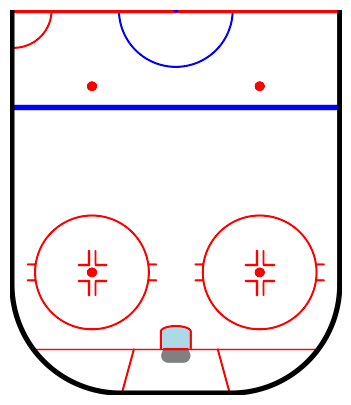

In [94]:
fig, axs = plt.subplots(figsize=(12, 5))
rink = Rink(rotation=270, boards={"length": 200, "width": 85})
rink.draw(display_range="offense", ax=axs)

zone_one = [(125, 0), (125,7.5), (200, 7.5), (200, 0)]

zone_one = Polygon(zone_one, closed = True, color = 'blue')